In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [65]:
import scipy.io as sio
import pickle

In [19]:
with open('var_sparse_snelson_7.pickle', 'rb') as handle:
    samples = pickle.load(handle)


In [48]:
M = 7
X_u = np.linspace(0,6, M)[:, None]
X_u_noisy = X_u + 0.1*np.random.rand(*X_u.shape) 

In [49]:
df = sio.loadmat('snelson1d.mat')
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [51]:
X1 = X[np.argsort(X, axis=0)]
Y1 = Y[np.argsort(X, axis=0)] 
X1 = X1.reshape(-1,1)
Y1 = Y1.reshape(-1,1)

In [52]:
M = 7
N_star = 200
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]

intervals = [(0.75,1.25), (2.5, 3.0), (4.25, 4.75)]

In [53]:
X_train, Y_train = X.copy(), Y.copy()
X_test, Y_test = [], [] 
test_indices = []
for a, b in intervals:
    indices = list(np.where(np.logical_and(X1.flatten() > a, X1.flatten() < b))[0] )
    if test_indices is None:
        test_indices = indices
    else:
        test_indices = test_indices + indices
#     print(test_indices)
# print(test_indices)
train_indices = np.arange(X.shape[0])
test_indices = np.asarray(test_indices)
train_indices = np.setdiff1d(train_indices, test_indices)
X_test, Y_test = X1[test_indices,:], Y1[test_indices]
X_train, Y_train = X1[train_indices,:], Y1[train_indices]

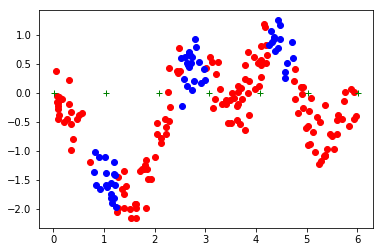

In [54]:
N_test = Y_test.size
plt.plot(X_train, Y_train, 'ro')
plt.plot(X_test, Y_test, 'bo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.size), 'g+')

In [55]:
sigma_samples = samples['sigma']
alpha_samples = samples['alpha']
rho_samples = samples['rho']
eta_samples = samples['eta']
N_samples = sigma_samples.size
sigma_mean = np.mean(samples['sigma'])
sigma_median = np.nanmedian(samples['sigma'])

l_mean = np.mean(samples['rho'])
l_median = np.nanmedian(samples['rho'])

sigvar_mean = np.mean(samples['alpha'])
sigvar_median = np.nanmedian(samples['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)

mean of noise variance: 0.43
median of noise variance: 0.43
mean of lengthscale: 0.940
median of lengthscale: 0.930
mean of signal variance: 0.935
median of signal variance: 0.894


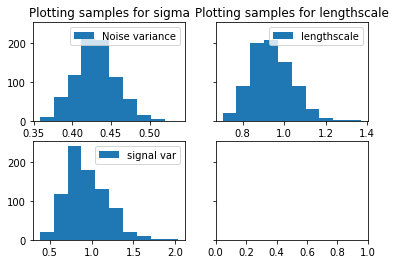

In [56]:
f, axs = plt.subplots(2,2, sharey=True)
axs[0,0].hist(sigma_samples)
axs[0,0].set_title('Plotting samples for sigma')
axs[0,0].legend(['Noise variance'])
axs[0,1].hist(rho_samples)
axs[0,1].set_title('Plotting samples for lengthscale')
axs[0,1].legend(['lengthscale'])
axs[1,0].hist(alpha_samples)
# axs[1,0].set_title('Plotting samples for signalvariance')
axs[1,0].legend(['signal var'])

In [57]:
def kernel_rbf(alpha, rho, Xi, Xj=None):
    if Xj is None:
        Xj = Xi
    
    N1,D1 = Xi.shape[0],1
    N2,D2 = Xj.shape[0],1
    
    diff = Xi.reshape(N1,1,D1) - Xj.reshape(1,N2,D2)
    K = (alpha**2)*np.exp(-0.5*np.sum(np.square(diff),-1)/(rho)**2)
    return K

In [58]:
Kuu = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_u_noisy)
K_star_u = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_star, Xj=X_u_noisy)

In [59]:
# function to generate mean and covariance matrics ..

def generate_preds(alpha, rho, v, Xi, Xj):
    Kuu = kernel_rbf(alpha, rho, Xj)
    K_star_u = kernel_rbf(alpha, rho, Xi, Xj)
    K_star_star = kernel_rbf(alpha, rho, Xi)
    
    R = np.linalg.cholesky(Kuu)
    A = np.linalg.solve(R, np.transpose(K_star_u))
#     print(A.shape)
    A_T = np.transpose(A)
    f_star_mean = np.dot(A_T, v)
    Q_star_star = np.dot(A_T, A)
    
    S = K_star_star - Q_star_star
    return f_star_mean, S


In [60]:
f_sum = np.zeros(N_star)
f_sum2 = np.zeros(N_star)
S_sum = np.zeros((N_star,N_star))
S_diag = np.zeros(N_star)
for i in range(N_samples):
    f_star_mean, S = generate_preds(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:],  Xi=X_star, Xj=X_u_noisy)
    f_sum = f_sum + f_star_mean
    f_sum2 = f_sum2 + f_star_mean**2
    S_sum = S_sum + S
    S_diag = np.diag(S)

In [62]:
f_fin = f_sum / N_samples
cov_fin = S_diag/N_samples + f_sum2/N_samples - (f_sum/N_samples)**2

Plot for Prediction of latent function(f*) for 1D regression

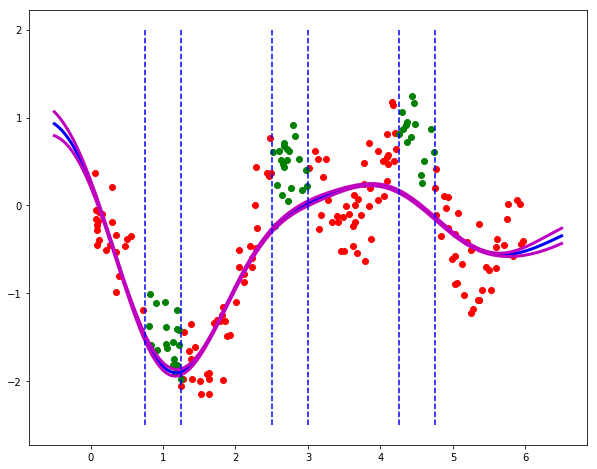

In [63]:
fig, ax = plt.subplots(1,1 , figsize=(10,8))
ax.plot(X_train, Y_train, 'ro')
ax.plot(X_test, Y_test, 'go')
ax.plot(X_star, f_fin, 'b-', lw=3)
ax.plot(X_star, f_fin + 2*cov_fin, 'm-', lw=3)
ax.plot(X_star, f_fin - 2*cov_fin, 'm-', lw=3)
for i in intervals:
    ax.plot([i[0], i[0]], [-2.5, 2], 'b--')
    ax.plot([i[1], i[1]], [-2.5, 2], 'b--')

Plot for Predictive observations(y) for 1D regression

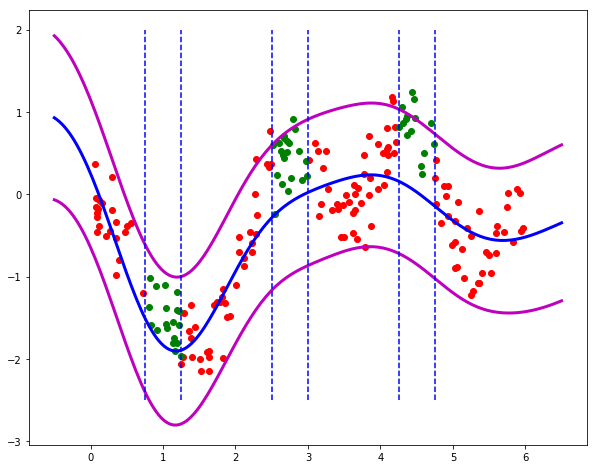

In [64]:
fig, ax = plt.subplots(1,1 , figsize=(10,8))
ax.plot(X_train, Y_train, 'ro')
ax.plot(X_test, Y_test, 'go')
ax.plot(X_star, f_fin, 'b-', lw=3)
plt.plot(X_star, f_fin + 2*cov_fin + 2*np.mean(sigma_samples, axis=0), 'm-', lw=3)
plt.plot(X_star, f_fin - 2*cov_fin -2*np.mean(sigma_samples, axis=0), 'm-', lw=3)
for i in intervals:
    ax.plot([i[0], i[0]], [-2.5, 2], 'b--')
    ax.plot([i[1], i[1]], [-2.5, 2], 'b--')

In [71]:
def RMSE(Y_star, Y_test):
    rmse = np.sqrt(np.mean(np.square(Y_star - Y_test)))
    return rmse

def NMSE(Y_star, Y_test):
    nmse = np.mean(np.square(Y_star - Y_test)) / np.mean(np.square(Y_test - np.mean(Y_test)))
    return nmse

def MLPPD(Y_star, Y_test, var_star):
    mlppd = 0.5* (np.mean(np.square(Y_star - Y_test)/var_star + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd

def MLPPD2(Y_star, Y_test, var_star):
    mlppd2 = 0.5* (np.sum(np.square(Y_star - Y_test)/(var_star*np.abs(Y_test)) + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd2

In [74]:
RMSE_test = RMSE(f_fin, Y_test)
NMSE_test = NMSE(f_fin, Y_test)
MLPPD_test1 = MLPPD(f_fin, Y_test, cov_fin)
# MLPPD_test2 = MLPPD(y_star_mean, Y_test, y_star_var)
MLPPD_test2 = MLPPD2(f_fin, Y_test, cov_fin+np.mean(sigma_samples, axis=0))
print("RMSE error: %.3f"%RMSE_test)
print("NMSE error: %.3f"%NMSE_test)

print("MLPPD: %.3f"%MLPPD_test1)
print("MLPPD2 : %.3f"%MLPPD_test2)



RMSE error: 1.293
NMSE error: 1.521
MLPPD: 0.357
MLPPD2 : 185.431
